# Appending & navigating simulations with given parameters

*Danilo Lessa Bernardineli* 

---


## Dependences

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

## Definitions

### Initial conditions and parameters

In [2]:
initial_conditions = {
    'prey_population': 100,
    'predator_population': 15
    }

params = {
    "prey_birth_rate": [1.0],
    "predator_birth_rate": [0.01],
    "predator_death_const": [1.0],
    "prey_death_const": [0.03],
    "dt": [0.01, 0.1, 0.05] # Precision of the simulation. Lower is more accurate / slower
}

simulation_parameters = {
    'N': 7,
    'T': range(200),
    'M': params
}

### Policies

In [3]:
def p_predator_births(params, step, sL, s):
  dt = params['dt']
  predator_population = s['predator_population']
  prey_population = s['prey_population']
  birth_fraction = params['predator_birth_rate'] + np.random.random() * 0.0002
  births =  birth_fraction * prey_population * predator_population * dt
  return {'add_to_predator_population': births}


def p_prey_births(params, step, sL, s):
  dt = params['dt']
  population = s['prey_population']
  birth_fraction = params['prey_birth_rate'] + np.random.random() * 0.1
  births =  birth_fraction * population * dt
  return {'add_to_prey_population': births}


def p_predator_deaths(params, step, sL, s):
  dt = params['dt']
  population = s['predator_population']
  death_rate = params['predator_death_const'] + np.random.random() * 0.005
  deaths = death_rate * population * dt
  return {'add_to_predator_population': -1.0 * deaths}


def p_prey_deaths(params, step, sL, s):
  dt = params['dt']
  death_rate = params['prey_death_const'] + np.random.random() * 0.1
  prey_population = s['prey_population']
  predator_population = s['predator_population']
  deaths = death_rate * prey_population * predator_population * dt
  return {'add_to_prey_population': -1.0 * deaths}

### State update functions

In [4]:
def s_prey_population(params, step, sL, s, _input):
    y = 'prey_population'
    x = s['prey_population'] + _input['add_to_prey_population']
    return (y, x)


def s_predator_population(params, step, sL, s, _input):
    y = 'predator_population'
    x = s['predator_population'] + _input['add_to_predator_population']
    return (y, x)

### State update blocks

In [5]:
partial_state_update_blocks = [
    { 
        'policies': {
            'predator_births': p_predator_births,
            'prey_births': p_prey_births,
            'predator_deaths': p_predator_deaths,
            'prey_deaths': p_prey_deaths,
        },
        'variables': {
            'predator_population': s_prey_population,
            'prey_population': s_predator_population
        }
    }
]

### Configuration and Execution

In [6]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=exp.configs) 
(records, tensor_field, _) = executor.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 3
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (200, 5, 7, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Ns       : [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.96s


### Results

In [7]:
import plotly.express as px

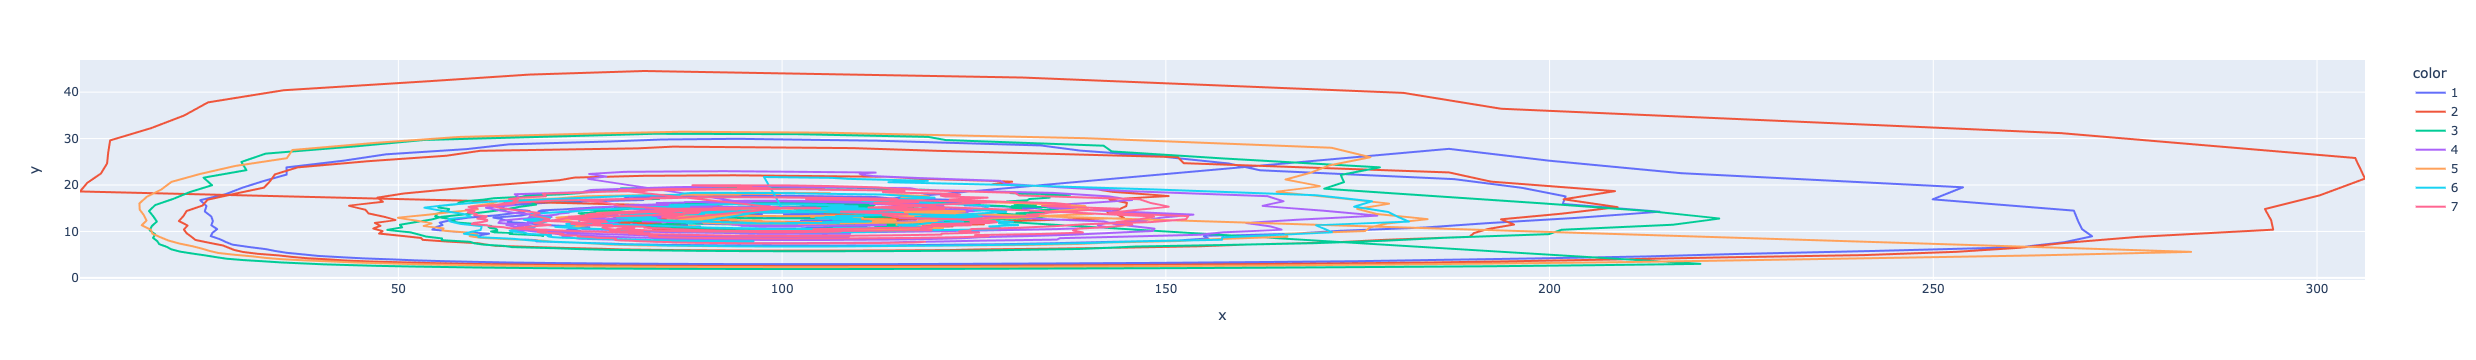

In [8]:
df = pd.DataFrame(records)

# Drop all intermediate substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = (first_ind | last_ind)
df = df.loc[inds_to_drop].drop(columns=['substep'])

# Attribute parameters to each row
df = df.assign(**configs[0].sim_config['M'])
for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    df.loc[n_df.index] = n_df.assign(**configs[i].sim_config['M'])

fig = px.line(df.query('dt == 0.1'),
              x=df.prey_population,
              y=df.predator_population,
              color=df.run.astype(str))

fig.show()